定量マクロ経済学_期末レポート
※授業で教授が記されたコードを参考に分析をしました。

0. 課題を解くための準備

In [30]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [31]:
# utility function

def util(cons, gamma):
    return max(cons, 1e-4)**(1.0-gamma)/(1.0-gamma)

In [32]:
# setting parameters

gamma = 2.0 # relative risk aversion
beta = 0.985**20 # time discount factor
r = 1.025**20 - 1.0 # interest rate
JJ = 3 # 期間数
l = np.array([0.8027, 1.0, 1.2457]) # 若年期の労働所得, 生産性・中生産性・高生産性
NL = 3 # 若年期の労働所得パターン数

# 各個人の中年期の労働所得は若年期の労働所得に依存 その確率はこの遷移行列によって決まる
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
]) 

# 1期目の所得状態の「確率分布」mu_1 が、probを通じて、2期目にどう分布するか
mu_1 = np.array([1.0/NL, 1.0/NL, 1.0/NL])
mu_2 = np.zeros(NL)

for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il, ilp]*mu_1[il] 

In [33]:
# grids
a_l = 0.0
a_u = 2.0
NA = 100
a = np.linspace(a_l, a_u, NA)

1. 年金がない場合、横軸に若年期期初の利子を除く資産、縦軸に次期の利子を除く資産とする貯蓄の政策関数のグラフをそれぞれの生産性について描け。
全て同じ1つの図に描くこと。異なる生産性での貯蓄行動を比較し、その経済学的な直感も述べよ。

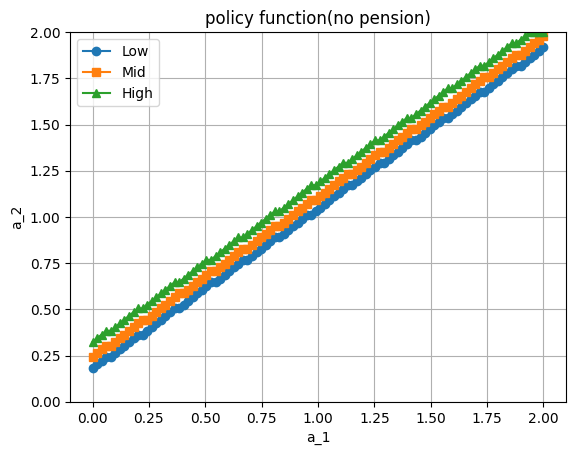

In [34]:
# initialization
v_no_pension = np.zeros((JJ, NA, NL))
iaplus_no_pension = np.zeros((JJ, NA, NL), dtype=int)
aplus_no_pension = np.zeros((JJ, NA, NL))

# backward induction

# period 3
for ia in range(NA):
    v_no_pension[2, ia, :] = util(0 + (1.0+r)*a[ia], gamma)

 # period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*v_no_pension[2, iap, 0]
        iaplus_no_pension[1, ia, il] = np.argmax(reward)
        aplus_no_pension[1, ia, il] = a[iaplus_no_pension[1, ia, il]]
        v_no_pension[1, ia, il] = reward[iaplus_no_pension[1, ia, il]]

# period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):

            EV = 0.0
            for ilp in range(NL):
                EV += prob[il, ilp]*v_no_pension[1, iap, ilp]

            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*EV

        iaplus_no_pension[0, ia, il] = np.argmax(reward)
        aplus_no_pension[0, ia, il] = a[iaplus_no_pension[0, ia, il]]
        v_no_pension[0, ia, il] = reward[iaplus_no_pension[0, ia, il]]

#図の描写
plt.figure()
plt.plot(a, aplus_no_pension[0, :, 0], marker='o', label='Low')
plt.plot(a, aplus_no_pension[0, :, 1], marker='s', label='Mid')
plt.plot(a, aplus_no_pension[0, :, 2], marker='^', label='High')
plt.title("policy function(no pension)")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()


2. 老年期にすべての個人に年金を支給することを考える。そのための原資として、中年期にのみ労働所得に対して定率30%の所得税を課す。
中年期における政府の総税収はいくらか？
政府はその総税収を利子率個人の資産と同じ利子率で運用し、老年期にそこから個人個人に均等に定額の年金を給付する。一人当たりの年金額を求めよ。

In [35]:
# 中年期の人口分布 mu_2 はすでに計算済み
print(mu_2) #すでに算出済み。確認

# 中年期の税収（定率30%）
tax_rate = 0.3
tax_revenue = 0.0

for il in range(NL):
    tax_revenue += tax_rate * l[il] * mu_2[il]  # 税収 = 各生産性層からの税収 * 人口割合

# 政府が利子付きで運用
pension_fund = tax_revenue * (1.0 + r)

# 全員に均等に給付（mu_2の合計 = 1なので割る必要なし）
pension_per_person = pension_fund

# 結果出力
print(f"中年期の政府税収：{tax_revenue:.4f}")
print(f"年金基金（利子付き）：{pension_fund:.4f}")
print(f"1人あたりの年金額：{pension_per_person:.4f}")

[0.2944     0.41123333 0.2944    ]
中年期の政府税収：0.3043
年金基金（利子付き）：0.4986
1人あたりの年金額：0.4986


3. 問2の年金が導入された場合の個人の最適化問題を再度解き、問1と同様にグラフを描き、
年金導入前と導入後の貯蓄行動を比較せよ。その経済学的な直感も述べよ。

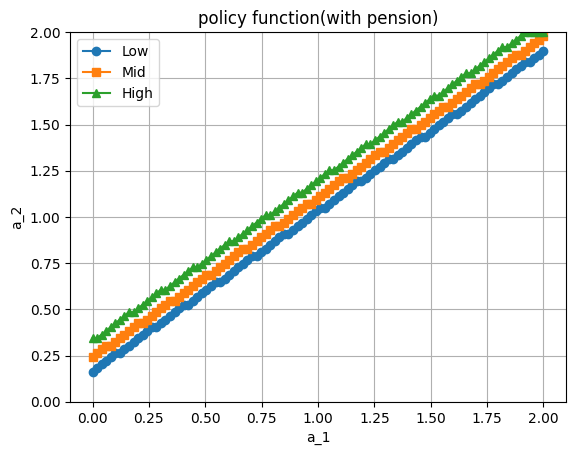

In [36]:
# initialization
v_with_pension = np.zeros((JJ, NA, NL))
iaplus_with_pension = np.zeros((JJ, NA, NL), dtype=int)
aplus_with_pension = np.zeros((JJ, NA, NL))

# backward induction

# period 3
for ia in range(NA):
    v_with_pension[2, ia, :] = util(pension_per_person + (1.0+r)*a[ia], gamma)

 # period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            reward[iap] = util((1.0-tax_rate)*l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*v_with_pension[2, iap, 0]
        iaplus_with_pension[1, ia, il] = np.argmax(reward)
        aplus_with_pension[1, ia, il] = a[iaplus_with_pension[1, ia, il]]
        v_with_pension[1, ia, il] = reward[iaplus_with_pension[1, ia, il]]

# period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):

            EV = 0.0
            for ilp in range(NL):
                EV += prob[il, ilp]*v_with_pension[1, iap, ilp]

            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*EV

        iaplus_with_pension[0, ia, il] = np.argmax(reward)
        aplus_with_pension[0, ia, il] = a[iaplus_with_pension[0, ia, il]]
        v_with_pension[0, ia, il] = reward[iaplus_with_pension[0, ia, il]]

#図の描写
plt.figure()
plt.plot(a, aplus_with_pension[0, :, 0], marker='o', label='Low')
plt.plot(a, aplus_with_pension[0, :, 1], marker='s', label='Mid')
plt.plot(a, aplus_with_pension[0, :, 2], marker='^', label='High')
plt.title("policy function(with pension)")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()


4. ここで全員の若年期の期初の資産をゼロとする。若年期の異なる生産性タイプの期待生涯効用を人口比率で加重平均した「経済全体の平均期待生涯効用」は、年金導入によって増
加するか、減少するか？その経済学的な直感とともに、このシミュレーションによると日本で年金の制度は維持すべきなのか論じよ。

In [37]:
a0_index = 0  # 若年期の期初の資産をゼロとする
print(mu_1) #すでに算出済み。確認

# 経済全体の平均期待生涯効用_年金なし
V0_no_pension = 0.0
for il in range(NL):
    V0_no_pension += mu_1[il] * v_no_pension[0, a0_index, il]

# 経済全体の平均期待生涯効用_年金あり
V0_with_pension = 0.0
for il in range(NL):
    V0_with_pension += mu_1[il] * v_with_pension[0, a0_index, il]

# それぞれの経済全体の平均期待生涯効用の差
diff = V0_with_pension - V0_no_pension

# 結果の出力
print(f"経済全体の平均期待生涯効用（年金なし）: {V0_no_pension:.4f}")
print(f"経済全体の平均期待生涯効用（年金あり）: {V0_with_pension:.4f}")
print(f"差分（あり−なし）: {diff:.4f}")

[0.33333333 0.33333333 0.33333333]
経済全体の平均期待生涯効用（年金なし）: -2.8370
経済全体の平均期待生涯効用（年金あり）: -2.8196
差分（あり−なし）: 0.0174


設問3の比較のための追加グラフ

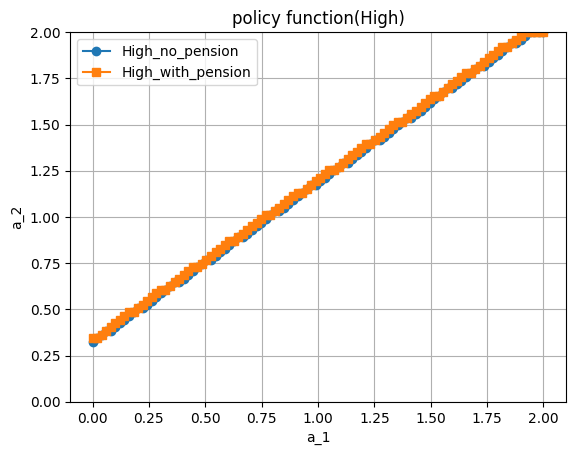

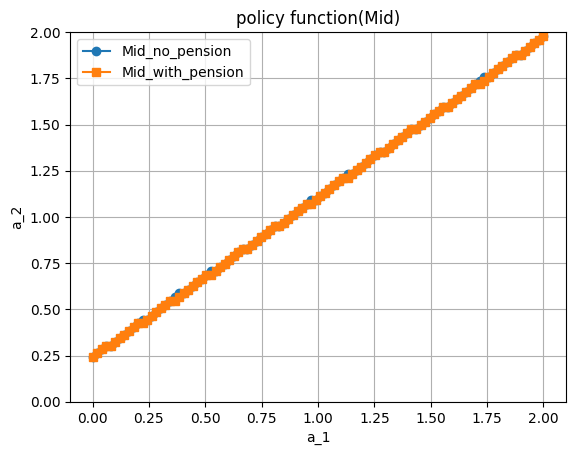

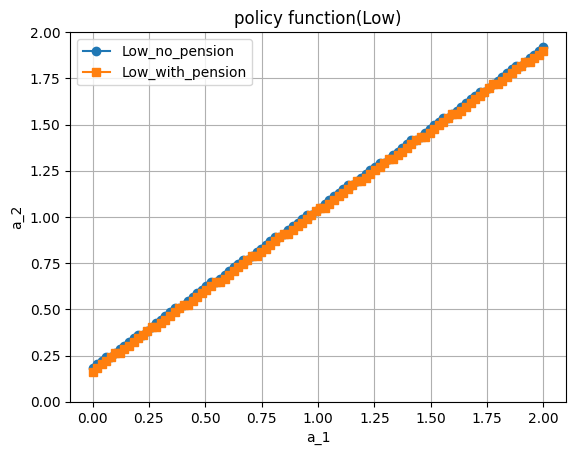

In [41]:
# 高生産性の比較
plt.figure()
plt.plot(a, aplus_no_pension[0, :, 2], marker='o', label='High_no_pension')
plt.plot(a, aplus_with_pension[0, :, 2], marker='s', label='High_with_pension')
plt.title("policy function(High)")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()

# 中生産性の比較
plt.figure()
plt.plot(a, aplus_no_pension[0, :, 1], marker='o', label='Mid_no_pension')
plt.plot(a, aplus_with_pension[0, :, 1], marker='s', label='Mid_with_pension')
plt.title("policy function(Mid)")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()

# 低生産性の比較
plt.figure()
plt.plot(a, aplus_no_pension[0, :, 0], marker='o', label='Low_no_pension')
plt.plot(a, aplus_with_pension[0, :, 0], marker='s', label='Low_with_pension')
plt.title("policy function(Low)")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()
